**Author:** Atharva Pandhare

---

# Imports and stuff

In [1]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time

# Define relevant variables for the ML task
batch_size = 64
learning_rate = 0.01
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# For training data
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# For test data
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Architectures

## LeNet Architecture

|name|output size|
|---|---|
|Input|32x32x3|
|conv(kernel = 5, output channels = 6)|28x28x6|
|MaxPool(window = 2)|16x16x6|
|conv(kernel = 5, output channels = 16)|12x12x16|
|MaxPool(window = 2)|6x6x16|
|linear|120|
|linear|84|
|linear|10|


In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.LazyConv2d(out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

            nn.LazyLinear(out_features=120),
            nn.ReLU(),

            nn.LazyLinear(out_features=84),
            nn.ReLU(),

            nn.LazyLinear(out_features=10)
        )
        
    def forward(self, x):
        output = self.net(x)

        return output

## LeNet Architecture with Dropout

|name|output size|
|---|---|
|Input|32x32x3|
|conv(kernel = 5, output channels = 6)|28x28x6|
|MaxPool(window = 2)|16x16x6|
|conv(kernel = 5, output channels = 16)|12x12x16|
|MaxPool(window = 2)|6x6x16|
|linear|120|
|Dropout|120|
|linear|84|
|linear|10|


In [4]:
class LeNet_v1(nn.Module):
    def __init__(self, conv_dropout_rate = 0.2, fc_dropout_rate=0.5):
        super(LeNet_v1, self).__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.LazyConv2d(out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

            nn.LazyLinear(out_features=120),
            nn.ReLU(),

            nn.Dropout(fc_dropout_rate),

            nn.LazyLinear(out_features=84),
            nn.ReLU(),
            
            nn.LazyLinear(out_features=10)
        )

    def forward(self, x):
        output = self.net(x)
        return output

## LeNet Architecture with Dropout and Batch Normalization

|name|output size|
|---|---|
|Input|32x32x3|
|conv(kernel = 5, output channels = 6)|28x28x6|
|Batch Normalization|28x28x6|
|MaxPool(window = 2)|16x16x6|
|conv(kernel = 5, output channels = 16)|12x12x16|
|MaxPool(window = 2)|6x6x16|
|linear|120|
|Dropout|120|
|linear|84|
|linear|10|


In [5]:
class LeNet_v2(nn.Module):
    def __init__(self, fc_dropout_rate=0.5):
        super(LeNet_v2, self).__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.LazyConv2d(out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

            nn.LazyLinear(out_features=120),
            nn.ReLU(),

            nn.Dropout(fc_dropout_rate),

            nn.LazyLinear(out_features=84),
            nn.ReLU(),

            nn.LazyLinear(out_features=10)
        )

    def forward(self, x):
        output = self.net(x)
        return output

# Train and Test Functions

In [6]:
def train(model, trainloader, num_epochs=num_epochs):
    start_time = time.time()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    # Lists to store losses for plotting
    epoch_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        
        running_loss = 0.0
        batches_in_epoch = 0
        
        for i, (inputs, labels) in enumerate(trainloader):
            # Move data to device (CPU/GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Accumulate statistics
            running_loss += loss.item()
            batches_in_epoch += 1
        
        # Store average loss for this epoch
        avg_epoch_loss = running_loss / batches_in_epoch
        epoch_losses.append(avg_epoch_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_epoch_loss:.3f}')
    
    # Plot the training loss
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds")
    
    # return epoch_losses

def test(model, testloader):
    start_time = time.time()
    # Testing the best model on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'testing finished in {elapsed_time:.2f} seconds, Accuracy: {accuracy:.2f}%')

# Training and Testing

## Regular

Epoch 1, Loss: 1.980
Epoch 2, Loss: 1.539
Epoch 3, Loss: 1.385
Epoch 4, Loss: 1.277
Epoch 5, Loss: 1.189
Epoch 6, Loss: 1.130
Epoch 7, Loss: 1.073
Epoch 8, Loss: 1.024
Epoch 9, Loss: 0.975
Epoch 10, Loss: 0.942
Epoch 11, Loss: 0.908
Epoch 12, Loss: 0.868
Epoch 13, Loss: 0.841
Epoch 14, Loss: 0.812
Epoch 15, Loss: 0.785
Epoch 16, Loss: 0.762
Epoch 17, Loss: 0.736
Epoch 18, Loss: 0.716
Epoch 19, Loss: 0.692
Epoch 20, Loss: 0.684


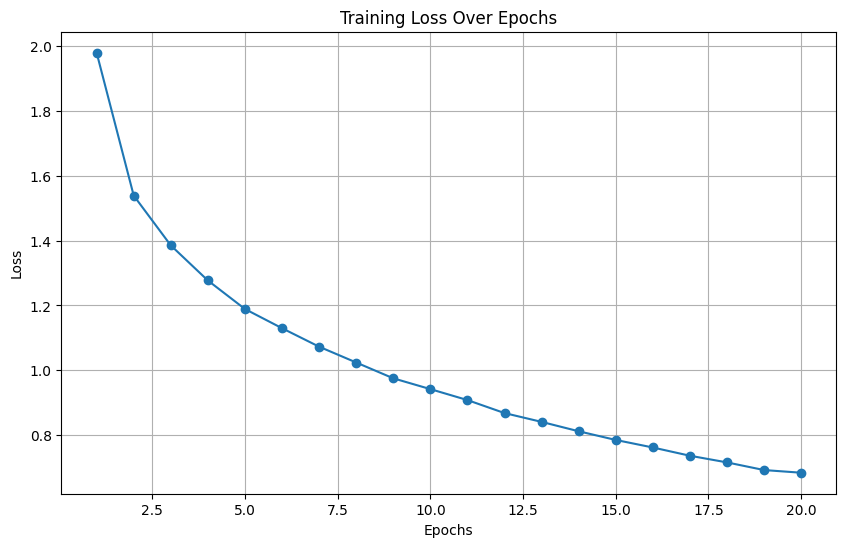

Training completed in 65.11 seconds


In [7]:
model = LeNet().to(device)
# DataLoader for training and test datasets
trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False)

train(model, trainloader)


In [8]:
test(model, testloader)

testing finished in 0.50 seconds, Accuracy: 60.16%


## With Dropout

Epoch 1, Loss: 2.115
Epoch 2, Loss: 1.685
Epoch 3, Loss: 1.531
Epoch 4, Loss: 1.460
Epoch 5, Loss: 1.404
Epoch 6, Loss: 1.371
Epoch 7, Loss: 1.325
Epoch 8, Loss: 1.306
Epoch 9, Loss: 1.277
Epoch 10, Loss: 1.253
Epoch 11, Loss: 1.223
Epoch 12, Loss: 1.212
Epoch 13, Loss: 1.190
Epoch 14, Loss: 1.179
Epoch 15, Loss: 1.169
Epoch 16, Loss: 1.149
Epoch 17, Loss: 1.133
Epoch 18, Loss: 1.119
Epoch 19, Loss: 1.104
Epoch 20, Loss: 1.100


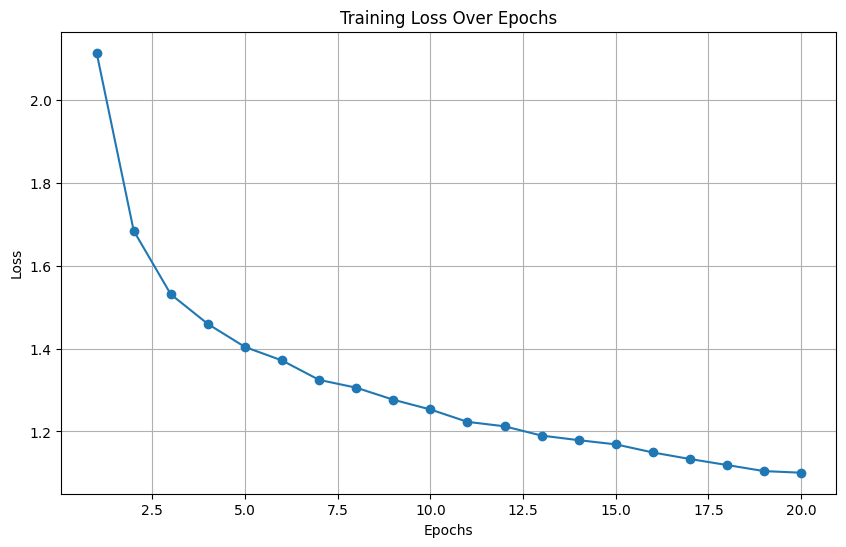

Training completed in 67.02 seconds


In [13]:
model1 = LeNet_v1().to(device)
# DataLoader for training and test datasets
trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False)

train(model1, trainloader)


In [14]:
test(model1, testloader)

testing finished in 0.49 seconds, Accuracy: 61.76%


## With Dropout and Batch Norm

Epoch 1, Loss: 1.705
Epoch 2, Loss: 1.426
Epoch 3, Loss: 1.319
Epoch 4, Loss: 1.260
Epoch 5, Loss: 1.217
Epoch 6, Loss: 1.178
Epoch 7, Loss: 1.154
Epoch 8, Loss: 1.128
Epoch 9, Loss: 1.110
Epoch 10, Loss: 1.083
Epoch 11, Loss: 1.068
Epoch 12, Loss: 1.054
Epoch 13, Loss: 1.046
Epoch 14, Loss: 1.036
Epoch 15, Loss: 1.018
Epoch 16, Loss: 1.008
Epoch 17, Loss: 1.001
Epoch 18, Loss: 0.996
Epoch 19, Loss: 0.983
Epoch 20, Loss: 0.979


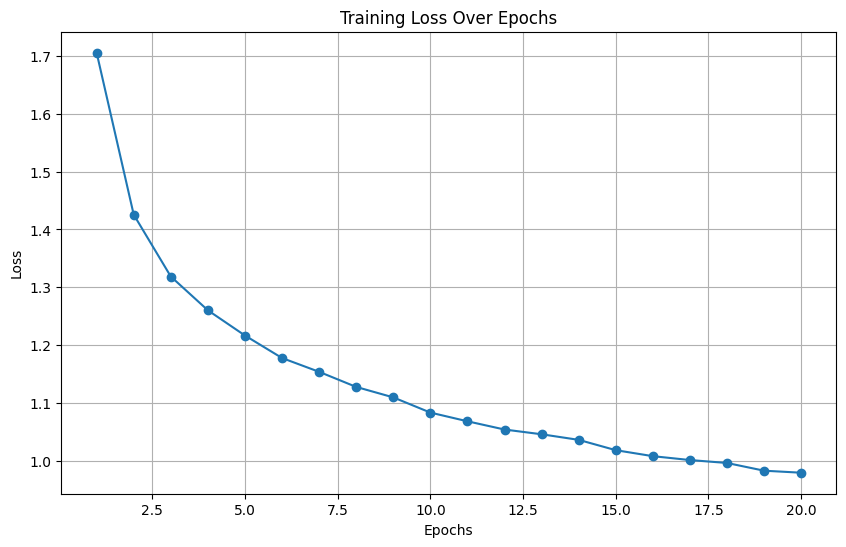

Training completed in 67.48 seconds


In [11]:
model2 = LeNet_v2().to(device)
# DataLoader for training and test datasets
trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False)

train(model2, trainloader)


In [12]:
test(model2, testloader)

testing finished in 0.51 seconds, Accuracy: 65.26%


# Conclusion

I used a batch size of 64, as it gave me better performance than 128, 256. The smaller batch size allowed for more frequent weight updates, which helped the model navigate the loss landscape more effectively. While larger batches could potentially use GPU resources more efficiently, the 64 batch size struck the right balance between computational efficiency and learning dynamics for this CIFAR-10 classification task.

The learning rate of 0.01 with SGD optimizer and momentum of 0.9 provided stable convergence without oscillation issues. Training for 20 epochs was sufficient to demonstrate the differences between the model variations while avoiding overfitting in the base model.

## Dropout
Adding dropout to the LeNet architecture shows significant improvement in preventing overfitting:
- Acts as a regularization technique by randomly "dropping" neurons during training
- Forces the network to learn more robust features that don't rely on specific neurons
- Creates an implicit ensemble effect, as each training iteration uses a different subset of neurons

## Dropout + Batch Normalization
Combining dropout with batch normalization further enhances model performance:
- Batch normalization stabilizes the learning process by normalizing layer inputs
- Reduces internal covariate shift, allowing for higher learning rates
- Works synergistically with dropout to improve both training speed and generalization
- Helps mitigate vanishing/exploding gradient problems in deeper networks

These did not improve the accuracy too much, but a win is a win
